<a href="https://colab.research.google.com/github/valeriopagliarino/Electronics-2021-UNITO/blob/main/analysis/2_OPA_integ_deriv_log.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data analysis: integration, differentiation and log with OPA
### October 5th 2021
<p>
Authors: <b> Stefano Barbero, Valerio Pagliarino, Matteo Barbagiovanni, Federico Malnati </b> <p>Electronics Laboratory 2021 - Department of Physics - University of Turin <p>
Date: 05/10/2021

1. OPA integrator
2. OPA differentiator
3. OPA log amplifier


OPA: LM471CV (https://www.ti.com/lit/ds/symlink/lm741.pdf)


## Configuration

### Clone the GIT

In [1]:
!rm -r ./sample_data
import os
from getpass import getpass
user = input('GitHub user')
mail = input('GitHub email')
password = getpass('GitHub password')
os.environ['GITHUB_AUTH'] = user + ':' + password
!git clone https://$GITHUB_AUTH@github.com/valeriopagliarino/Electronics-2021-UNITO.git
!git config --global user.email user
!git config --global user.name mail

GitHub uservaleriopagliarino
GitHub emailvalerio.pagliarino@edu.unito.it
GitHub password··········
Cloning into 'Electronics-2021-UNITO'...
remote: Enumerating objects: 1071, done.
remote: Counting objects: 100% (1071/1071), done.
remote: Compressing objects: 100% (769/769), done.
remote: Total 1071 (delta 553), reused 644 (delta 277), pack-reused 0
Receiving objects: 100% (1071/1071), 41.63 MiB | 23.81 MiB/s, done.
Resolving deltas: 100% (553/553), done.


### Install environment

In [2]:
exec(open("./Electronics-2021-UNITO/analysis/ROOT-config.py").read())

Start config for JupyROOT Env. on Google Coolab - It takes about 3 minutes
WGET...
Done.
UNZIP...
TAR...
APT...
Installation completed.
Shared objects loaded.
Welcome to JupyROOT 6.14/04
Completed!


### Importa moduli [no COLAB]

In [ ]:
import numpy as np
import scipy as sp
import sympy as sy
import pandas as pd

from matplotlib import pyplot as plt

from uncertainties import ufloat
import uncertainties.umath

import pickle

import ROOT # Per COLAB importato da ROOT-config.py

DATADIR = "../data-source"
OUTPUTDIR = "./output"

### Importa moduli [COLAB]

In [13]:
!pip3 install uncertainties
import numpy as np
import scipy as sp
import sympy as sy
import pandas as pd

from uncertainties import ufloat
import uncertainties.umath
from matplotlib import pyplot as plt
import pickle #Pickle with dict of Numpy arrays

exec(open("/content/Electronics-2021-UNITO/analysis/utilities.py").read())

# Variables for directories
DATADIR = "/content/Electronics-2021-UNITO/data-source"
OUTPUTDIR = "/content/Electronics-2021-UNITO/analysis/output"

### Funzioni per l'importazione file Tektronix

In [4]:
import csv

def cellFromCSV(path, row_index, col_index):
  with open(path, 'r') as f:
    mycsv = csv.reader(f)
    column = []
    for row in mycsv:
        column.append(row[col_index])

  return column[row_index]


def openTek(path):
  a = pd.read_table(path, header=None, sep=",", usecols=[3,4])
  a = a.transpose()
  a = a.rename(index={3: 'Time', 4: 'Amplitude'})
  a = a.transpose()

  data = {'Record lenght': cellFromCSV(path, 0, 1),
          'Sample interval': cellFromCSV(path, 1, 1),
          'Trigger point': cellFromCSV(path, 2, 1),
          'Source': cellFromCSV(path, 6, 1),
          'Vertical units': cellFromCSV(path, 7, 1),
          'Vertical scale': cellFromCSV(path, 8, 1),
          'Vertical offset': cellFromCSV(path, 9, 1),
          'Horizontal units': cellFromCSV(path, 10, 1),
          'Horizontal scale': cellFromCSV(path, 11, 1),
          'Pt FMT': cellFromCSV(path, 12, 1),
          'Y zero': cellFromCSV(path, 13, 1),
          'Probe atten': cellFromCSV(path, 14, 1),
          'Model': cellFromCSV(path, 15, 1),
          'Serial': cellFromCSV(path, 16, 1),
          'Firmware': cellFromCSV(path, 17, 1),
          'Data' : a
  }
  return data

## OPA log-amplifier XY plot

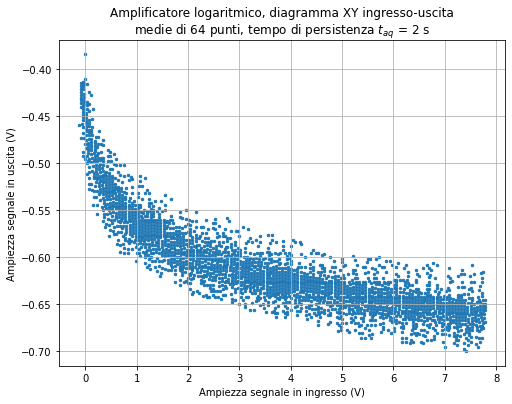

In [84]:
logXY = pd.read_csv(f"{DATADIR}/5-10-21/OPA_log_XY_plot/TEK00XY01.csv")
x_data = logXY.to_numpy().transpose()[0]  + 3.6  #Offset traslazione canali
y_data = logXY.to_numpy().transpose()[1]  - 0.54 #Offset traslazione canali


fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(8, 6))
ax.scatter(x_data, y_data, s=6)

ax.set(xlabel='Ampiezza segnale in ingresso (V)', ylabel='Ampiezza segnale in uscita (V)',
       title='Amplificatore logaritmico, diagramma XY ingresso-uscita\nmedie di 64 punti, tempo di persistenza $t_{aq}$ = 2 s')

ax.grid()

plt.savefig(f"{OUTPUTDIR}/OPA-log-AMP-XY.pdf")

### OPA log-amplifier overlap with data series & fit

 FCN=11.9626 FROM MINOS     STATUS=SUCCESSFUL     46 CALLS         338 TOTAL
                     EDM=5.03587e-09    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  V_{T}        2.10137e-02   4.48839e-04  -8.83378e-06  -3.37420e+01
   2  I_{0}        6.08756e-10   1.84460e-10   1.84460e-10   7.19484e+06


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


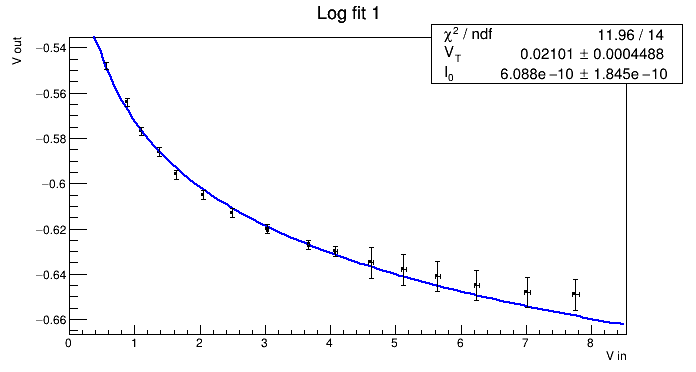

In [101]:
from uncertainties import umath

df_data = pd.read_csv(f'{DATADIR}/5-10-21/logaritmico/data.csv')
df_data = df_data[:-4]
df_errors = 0.5/100. * df_data # 0.5 %
df_errors[:10] += 0.001 # 1dgt
df_errors[10:] += 0.01 # 1dgt

Vin_arr = pair_dat_err(df_data['Vin [V]'], df_errors['Vin [V]'])
Vout_arr = pair_dat_err(df_data['Vout [V]'], df_errors['Vout [V]'])

canvas = ROOT.TCanvas("c1", "log fit 1", 700, 400)
#canvas.SetLogx(True)

fit_log_graph_err = uncertainties_to_root_graph_errors(Vin_arr, Vout_arr)
fit_log_graph_err.SetTitle("Log fit 1")
fit_log_graph_err.GetXaxis().SetTitle("V in")
fit_log_graph_err.GetYaxis().SetTitle("V out")
fit_log_graph_err.SetMarkerStyle(21)
fit_log_graph_err.SetMarkerSize(0.4)

function_formula = "- 2 * [0] * log(x / (1995 * [1]))"
fit_f = ROOT.TF1("fit1", function_formula)
fit_f.SetLineColor(4)
fit_f.SetParName(0, "V_{T}")
fit_f.SetParName(1, "I_{0}")
fit_f.SetParameter(0, 0.026)
fit_f.SetParameter(1, 1e-9)

ROOT.gStyle.SetOptFit(True)

canvas.Draw()
fit_log_graph_err.Draw("ap")
fit_log_graph_err.Fit(fit_f, "MSE")

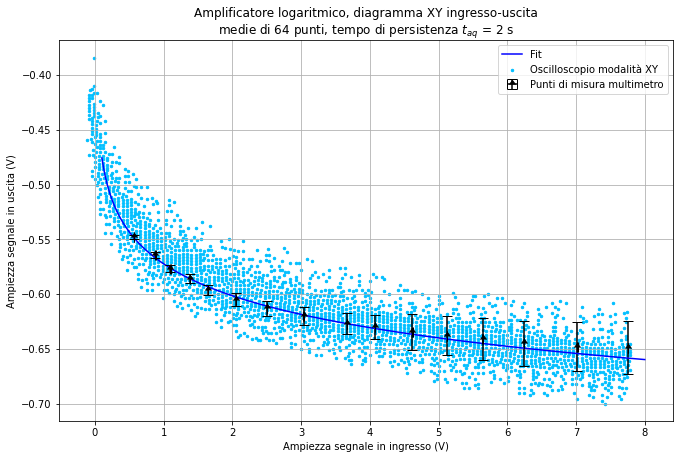

In [112]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(11, 7))
x_fit   = np.linspace(0.1, 8, 200)
y_fit   = - 2 * fit_f.GetParameter(0) * np.log(x_fit / (1995 * fit_f.GetParameter(1)))
ax.scatter(x_data, y_data, s=6, color="deepskyblue", label = "Oscilloscopio modalità XY")
ax.plot(x_fit, y_fit, "blue", label = "Fit")
ax.errorbar(df_data['Vin [V]'], df_data['Vout [V]'], df_errors['Vin [V]'] / 2, df_errors['Vout [V]'] / 2, 
            color = "black", label = "Punti di misura multimetro", linestyle = "none", marker = 10, capsize=5)

ax.set(xlabel='Ampiezza segnale in ingresso (V)', ylabel='Ampiezza segnale in uscita (V)',
       title='Amplificatore logaritmico, diagramma XY ingresso-uscita\nmedie di 64 punti, tempo di persistenza $t_{aq}$ = 2 s')

ax.grid()
ax.legend()

plt.savefig(f"{OUTPUTDIR}/OPA-log-fitted.pdf")

## OPA integrator - with discharging resistor

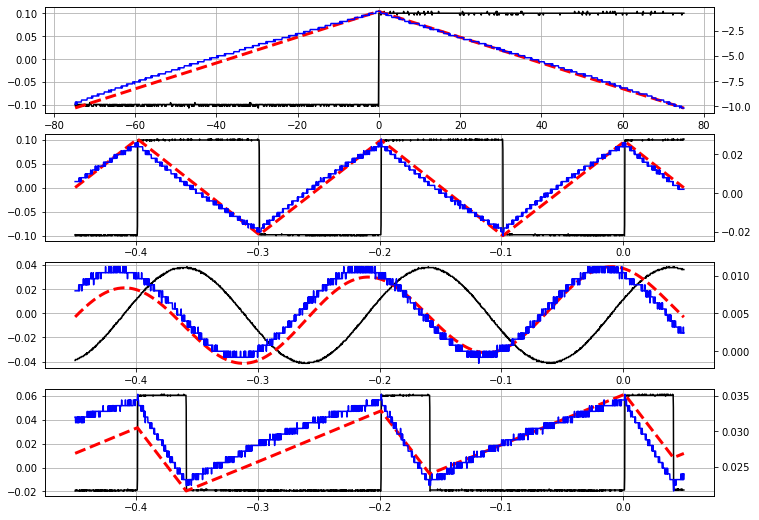

In [ ]:
in_step    = openTek(f'{DATADIR}/5-10-21/OPA_integ_with_res_step/F0002CH1.CSV')
out_step   = openTek(f'{DATADIR}/5-10-21/OPA_integ_with_res_step/F0002CH2.CSV')
in_square  = openTek(f'{DATADIR}/5-10-21/OPA_integ_with_res_square_wave/F0005CH1.CSV')
out_square = openTek(f'{DATADIR}/5-10-21/OPA_integ_with_res_square_wave/F0005CH2.CSV')
in_sine    = openTek(f'{DATADIR}/5-10-21/OPA_integ_with_res_sine/F0007CH1.CSV')
out_sine   = openTek(f'{DATADIR}/5-10-21/OPA_integ_with_res_sine/F0007CH2.CSV')
in_pmod    = openTek(f'{DATADIR}/5-10-21/OPA_integ_with_res_pulsemod/F0008CH1.CSV')
out_pmod   = openTek(f'{DATADIR}/5-10-21/OPA_integ_with_res_pulsemod/F0008CH2.CSV')

crop_in1 = 500
crop_out1 = 2000

crop_in2 = 0
crop_out2 = 2500

crop_in3 = 0
crop_out3 = 2500

time_in_step    = in_step['Data'].to_numpy().transpose()[0][crop_in1:crop_out1]   * 1000   
time_out_step   = out_step['Data'].to_numpy().transpose()[0][crop_in1:crop_out1]   * 1000  
time_in_square  = in_square['Data'].to_numpy().transpose()[0] * 1000 
time_out_square = out_square['Data'].to_numpy().transpose()[0] * 1000
time_in_sine    = in_sine['Data'].to_numpy().transpose()[0][crop_in2:crop_out2] * 1000   
time_out_sine   = out_sine['Data'].to_numpy().transpose()[0][crop_in2:crop_out2] * 1000    
time_in_pmod    = in_pmod['Data'].to_numpy().transpose()[0][crop_in3:crop_out3] * 1000   
time_out_pmod   = out_pmod['Data'].to_numpy().transpose()[0][crop_in3:crop_out3] * 1000  


sig_in_step     = in_step['Data'].to_numpy().transpose()[1][crop_in1:crop_out1]   
sig_out_step    = out_step['Data'].to_numpy().transpose()[1][crop_in1:crop_out1]  
sig_in_square   = in_square['Data'].to_numpy().transpose()[1] 
sig_out_square  = out_square['Data'].to_numpy().transpose()[1]
sig_in_sine     = in_sine['Data'].to_numpy().transpose()[1][crop_in2:crop_out2]   
sig_out_sine    = out_sine['Data'].to_numpy().transpose()[1][crop_in2:crop_out2] 
sig_in_pmod     = in_pmod['Data'].to_numpy().transpose()[1][crop_in3:crop_out3]   
sig_out_pmod    = out_pmod['Data'].to_numpy().transpose()[1][crop_in3:crop_out3]  

sig_in_step     = sig_in_step   - sig_in_step.mean() 
sig_in_square   = sig_in_square - sig_in_square.mean() 
sig_in_sine     = sig_in_sine   - sig_in_sine.mean() 
sig_in_pmod     = sig_in_pmod   - sig_in_pmod.mean() 
 


fig, ax = plt.subplots(nrows = 4, ncols = 1, figsize=(12, 9))

ax2 = []
for ax_2 in ax:
  ax2.append(ax_2.twinx())

def mm_norm(nn, ref):
  maxv = max(ref)
  minv = min(ref)
  return ((nn - min(nn)) / (max(nn) - min(nn))) * (maxv - minv) + minv


step_quadrature = sig_in_step.cumsum() * -1.
square_quadrature = sig_in_square.cumsum() * -1.
sine_quadrature = sig_in_sine.cumsum() * -1. + 1
pmod_quadrature = (sig_in_pmod).cumsum() * -1. 

ax[0].plot(time_in_step, sig_in_step, color = "black", label = "Gradino")
ax2[0].plot(time_in_step, mm_norm(step_quadrature, sig_out_step) , color = "red", linestyle = "--", linewidth=3)
ax2[0].plot(time_out_step, sig_out_step, color = "blue", label = "Integrale")

ax[1].plot(time_in_square, sig_in_square, color = "black", label = "Onda quadra")
ax2[1].plot(time_in_square, mm_norm(square_quadrature, sig_out_square) , color = "red", linestyle = "--", linewidth=3)
ax2[1].plot(time_out_square, sig_out_square, color = "blue", label = "Integrale")

ax[2].plot(time_in_sine, sig_in_sine, color = "black", label = "Sinusoide")
ax2[2].plot(time_in_sine, mm_norm(sine_quadrature, sig_out_sine) , color = "red", linestyle = "--", linewidth=3)
ax2[2].plot(time_out_sine, sig_out_sine, color = "blue", label = "Integrale")

ax[3].plot(time_in_pmod, sig_in_pmod, color = "black", label = "Treno di impulsi")
ax2[3].plot(time_in_pmod, mm_norm(pmod_quadrature, sig_out_pmod) , color = "red", linestyle = "--", linewidth=3)
ax2[3].plot(time_out_pmod, sig_out_pmod, color = "blue", label = "Integrale")


for ax_ in ax:
  ax_.grid()
  #ax_.legend(loc="upper left")



plt.savefig(f"{OUTPUTDIR}/OPA-integ-with-res.pdf")

## OPA differentiator

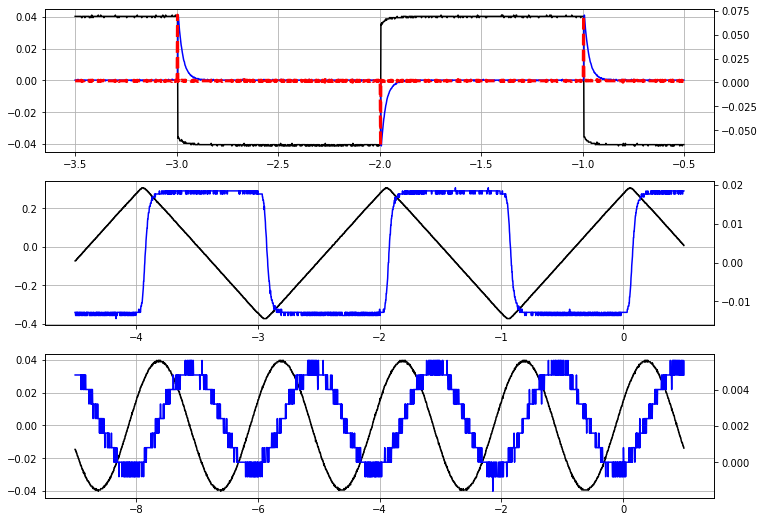

In [ ]:
in_dirac   = openTek(f'{DATADIR}/5-10-21/OPA_deriv_dirac_delta/F0009CH1.CSV')
out_dirac  = openTek(f'{DATADIR}/5-10-21/OPA_deriv_dirac_delta/F0009CH2.CSV')
in_triang  = openTek(f'{DATADIR}/5-10-21/OPA_deriv_triangle/F0011CH1.CSV')
out_triang = openTek(f'{DATADIR}/5-10-21/OPA_deriv_triangle/F0011CH2.CSV')
in_sine    = openTek(f'{DATADIR}/5-10-21/OPA_deriv_sine/F0010CH1.CSV')
out_sine   = openTek(f'{DATADIR}/5-10-21/OPA_deriv_sine/F0010CH2.CSV')

crop_in1 = 500
crop_out1 = 2000

crop_in2 = 0
crop_out2 = 2500

crop_in3 = 0
crop_out3 = 2500

time_in_dirac   = in_dirac['Data'].to_numpy().transpose()[0][crop_in1:crop_out1]   * 1000   
time_out_dirac  = out_dirac['Data'].to_numpy().transpose()[0][crop_in1:crop_out1]   * 1000  
time_in_triang  = in_triang['Data'].to_numpy().transpose()[0] * 1000 
time_out_triang = out_triang['Data'].to_numpy().transpose()[0] * 1000
time_in_sine    = in_sine['Data'].to_numpy().transpose()[0][crop_in2:crop_out2] * 1000   
time_out_sine   = out_sine['Data'].to_numpy().transpose()[0][crop_in2:crop_out2] * 1000    


sig_in_dirac    = in_dirac['Data'].to_numpy().transpose()[1][crop_in1:crop_out1]   
sig_out_dirac   = out_dirac['Data'].to_numpy().transpose()[1][crop_in1:crop_out1]  
sig_in_triang   = in_triang['Data'].to_numpy().transpose()[1] 
sig_out_triang  = out_triang['Data'].to_numpy().transpose()[1]
sig_in_sine     = in_sine['Data'].to_numpy().transpose()[1][crop_in2:crop_out2]   
sig_out_sine    = out_sine['Data'].to_numpy().transpose()[1][crop_in2:crop_out2]  

sig_in_dirac    = sig_in_dirac   - sig_in_dirac.mean() 
sig_in_triang   = sig_in_triang - sig_in_triang.mean() 
sig_in_sine     = sig_in_sine   - sig_in_sine.mean() 
 


fig, ax = plt.subplots(nrows = 3, ncols = 1, figsize=(12, 9))

ax2 = []
for ax_2 in ax:
  ax2.append(ax_2.twinx())

def mm_norm(nn, ref):
  maxv = max(ref)
  minv = min(ref)
  return ((nn - min(nn)) / (max(nn) - min(nn))) * (maxv - minv) + minv


dirac_d = np.diff(sig_in_dirac) * -1.
triang_d = np.diff(sig_in_triang) * -1.
sine_d = np.diff(sig_in_sine) * -1. + 1

ax[0].plot(time_in_dirac, sig_in_dirac, color = "black", label = "Onda quadra")
ax2[0].plot(time_out_dirac, sig_out_dirac, color = "blue", label = "Derivata")
ax2[0].plot(time_in_dirac[:-1], mm_norm(dirac_d, sig_out_dirac) , color = "red", linestyle = "--", linewidth=3)

ax[1].plot(time_in_triang, sig_in_triang, color = "black", label = "Onda triangolare")
#ax2[1].plot(time_in_triang[:-1], mm_norm(triang_d, sig_out_triang) , color = "red", linestyle = "--", linewidth=3)
ax2[1].plot(time_out_triang, sig_out_triang, color = "blue", label = "Derivata")

ax[2].plot(time_in_sine, sig_in_sine, color = "black", label = "Sinusoide")
#ax2[2].plot(time_in_sine[:-1], mm_norm(sine_d, sig_out_sine) , color = "red", linestyle = "--", linewidth=3)
ax2[2].plot(time_out_sine, sig_out_sine, color = "blue", label = "Derivata")

for ax_ in ax:
  ax_.grid()
  #ax_.legend(loc="upper left")



plt.savefig(f"{OUTPUTDIR}/OPA-differentiator.pdf")

## Commit changes

In [113]:
%cd /content/Electronics-2021-UNITO/
!git pull
!git add .
!git commit -m "Plots from data analysis"
!git push 

/content/Electronics-2021-UNITO
Already up to date.
[main 61fe849] Plots from data analysis
 2 files changed, 0 insertions(+), 0 deletions(-)
 create mode 100644 analysis/output/OPA-log-fitted.pdf
Counting objects: 6, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (6/6), done.
Writing objects: 100% (6/6), 31.02 KiB | 10.34 MiB/s, done.
Total 6 (delta 4), reused 0 (delta 0)
remote: Resolving deltas: 100% (4/4), completed with 4 local objects.
To https://github.com/valeriopagliarino/Electronics-2021-UNITO.git
   2a07897..61fe849  main -> main
